# Capstone Project: Hotel booking demand

To start of, we'll load some libaries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

Then, we'll load the data

In [3]:
file = './data/hotel_bookings.csv'
df = pd.read_csv(file)
print(df.shape)

(119390, 32)


and do a first check:

In [4]:
pd.set_option("display.max_columns", 32)
display(df.head())


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Data Preparation

Since the dataframe still holds NaN values, those need to be filled. Following the dataset's description, the NaN values actually hold information and just need to be transformed to reflect that.

In [5]:
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

The country variable does not need to be filled at the time of booking, so NaN values can occur here and need to be replaced.
If an agent variable is NaN, it means that the booking was not made via an agent, which is information as well.
Similarily, if company is NaN, the booking was made by a private customer. 
The four children NaN values will be set to 0.

Additionally, in the meal column, there exist two ways to display the same information. Undefined is equal to SC, so we will need to replace Undefined with SC. 

Utilizing knowlede required at a later stage, we will also remove observations with 0 customers.

In [6]:
df = df.fillna({'agent':0, 'company':0, 'country':'None', 'children':0})
df.meal.replace('Undefined', 'SC', inplace=True)
df.drop(list(df.loc[df.adults + df.children + df.babies == 0].index), inplace=True)

In [7]:
df.shape

(119210, 32)

Additionally, certain columns are not representing the right dtypes. 
According to the authors of the [paper](https://www.sciencedirect.com/science/article/pii/S2352340918315191), where the data was published, the following variables which are not yet categorical are supposed to be categorical: 

- agent
- company


In [8]:
display(df.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [8]:
df = df.astype({'agent': 'object', 'company': 'object'})

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119210 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119210 non-null  object 
 1   is_canceled                     119210 non-null  int64  
 2   lead_time                       119210 non-null  int64  
 3   arrival_date_year               119210 non-null  int64  
 4   arrival_date_month              119210 non-null  object 
 5   arrival_date_week_number        119210 non-null  int64  
 6   arrival_date_day_of_month       119210 non-null  int64  
 7   stays_in_weekend_nights         119210 non-null  int64  
 8   stays_in_week_nights            119210 non-null  int64  
 9   adults                          119210 non-null  int64  
 10  children                        119210 non-null  float64
 11  babies                          119210 non-null  int64  
 12  meal            

## Data Exploration

We'll take a closer look at the data here.

### Target Variable

First off, we'll take a univariate look at the distribution of the target variable, to get a feel for the problem statement. 

In [10]:
df.groupby(['is_canceled'])['is_canceled'].count() / df.shape[0]

is_canceled
0    0.629234
1    0.370766
Name: is_canceled, dtype: float64

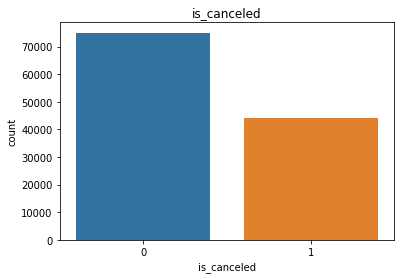

In [10]:
ax = sns.countplot('is_canceled', data = df)
ax.set_title("is_canceled")
plt.show()

### Hotel

We'll take a look at the distribution of cancelled bookings between hotels.

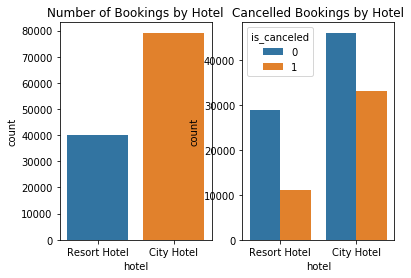

In [13]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sns.countplot(x = "hotel", data = df, ax = ax[0])
sns.countplot(x = "hotel", hue = "is_canceled", data = df, ax = ax[1])
ax[1].set_title("Cancelled Bookings by Hotel")
ax[0].set_title("Number of Bookings by Hotel")

#fig.savefig('bookings_by_hotel.png')

In [12]:
df.groupby(['hotel', 'is_canceled'])['is_canceled'].count() / df.shape[0]

hotel         is_canceled
City Hotel    0              0.386578
              1              0.277485
Resort Hotel  0              0.242656
              1              0.093281
Name: is_canceled, dtype: float64

### Agents

Agents are difficult, because a small portion of agents manage most of the bookings. For this purpose, we might include only a few agents as categorical variables in the data, and fill the others with different values

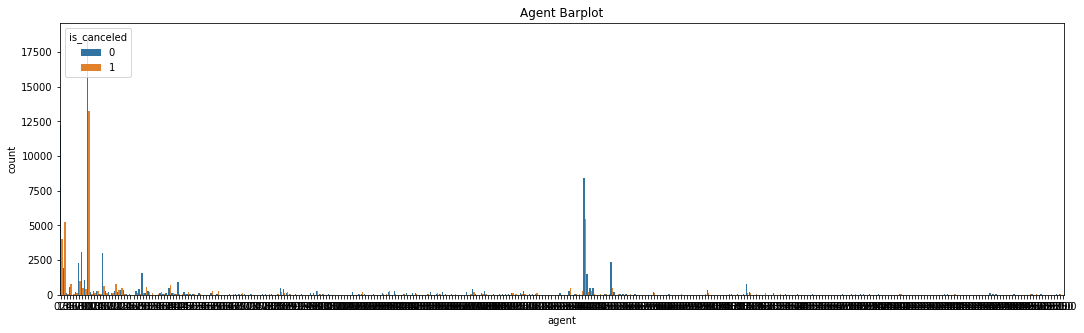

In [13]:
fig, ax = plt.subplots(1,1, figsize = (18, 5))
sns.countplot(x = 'agent', hue = 'is_canceled', data = df, ax = ax)
ax.set_title("Agent Barplot")
plt.show()

In [14]:
df.agent.describe()

count     119210.0
unique       334.0
top            9.0
freq       31922.0
Name: agent, dtype: float64

In [15]:
df.agent.value_counts(normalize=True).head(10)

9.0      0.267780
0.0      0.136566
240.0    0.116786
1.0      0.060289
14.0     0.030476
7.0      0.029628
6.0      0.027598
250.0    0.024075
241.0    0.014437
28.0     0.013900
Name: agent, dtype: float64

In [16]:
df.meal.value_counts(normalize=True)

BB    0.773727
HB    0.121282
SC    0.098297
FB    0.006694
Name: meal, dtype: float64

### ADR
The average daily rate of the bookings is an important indicator, so we will visualise it to discuss it in more detail in the report

In [17]:
df.adr.describe()

count    119210.000000
mean        101.969092
std          50.434007
min          -6.380000
25%          69.500000
50%          94.950000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

In [20]:
# This filters the unrealistic values out of the data.frame
df = df[df['adr'] > 0]
df = df[df['adr'] < 5200]

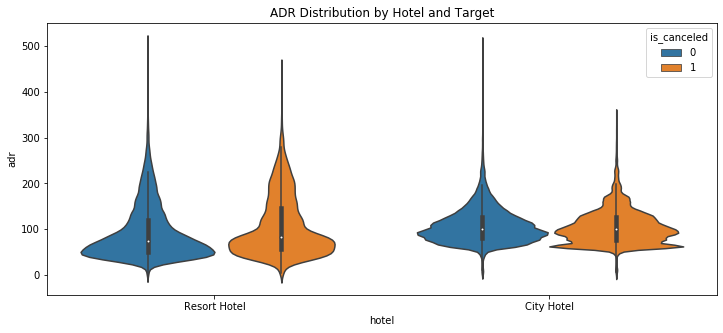

In [25]:
fig, ax = plt.subplots(1,1, figsize = (12, 5))
sns.violinplot(x = 'hotel', y = 'adr',hue = 'is_canceled', data = df, ax = ax)
ax.set_title("ADR Distribution by Hotel and Target")
plt.show()

#fig.savefig('adr_dist_by_hotel.png')

### Lead time

The lead time might indicate an important variable as well, because longer lead times tend to be more carefully planned stays which might be canceled less

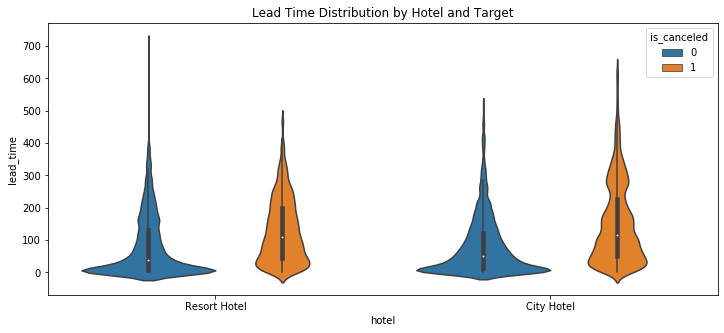

In [26]:
fig, ax = plt.subplots(1,1, figsize = (12, 5))
sns.violinplot(x = 'hotel', y = 'lead_time',hue = 'is_canceled', data = df, ax = ax)
ax.set_title("Lead Time Distribution by Hotel and Target")
plt.show()

#fig.savefig('lead_time_dist_by_hotel.png')

## Feature Engineering, Preprocessing and Selection

This section includes feature engineering and preprocessing, like one-hot encoding and removal of possible leakage variables.

Categorical Variables: 
- is_canceled (target variable) 
- hotel (one-hot encoding)
- arrival_data_month (one-hot encoding, essentially a seasonal variable)
- meal (one-hot encoding)
- country (one-hot; drop; aggregate?)
- market_segment (one-hot, possibly correlated with agent)
- distribution_channel (one-hot, little variance)
- reserved room type
- assigned room type
- deposit_type
- agent
- company (remove: ID Variable with too much noise) 
- customer_type
- reservation_status (remove: possible leakage)
- reservation_status_date (remove: possible leakage)

In [27]:
# Agent encoding
# We fill it with -99 for now. Should be fine since we one-hot encode this column later
top_eight = df.agent.value_counts(normalize=True).index.tolist()[8:]

df.replace(top_eight, -99, inplace=True)

In [28]:
num_features = ["lead_time", "arrival_date_week_number", "arrival_date_day_of_month",
                "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled", "company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel", "agent", "arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

feature_set = num_features + cat_features

# Modelling

## Modelling Preparation

In [29]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from scipy import stats

Transforming categorical features

In [30]:
all_features = ['is_canceled'] + feature_set

model_df = df[all_features].copy()

In [31]:
model_df = pd.get_dummies(data = model_df, columns = cat_features)
model_df.shape

## Data Split

In [32]:
y = model_df["is_canceled"]
X = model_df.drop(["is_canceled"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)

In [36]:
display(y_train.shape)
display(y_test.shape)

(93918,)

(23480,)

## Benchmark ZeroRule

Here we will take a look at the performance of the Zero-Rule Benchmark. Meaning: How well would a model simply predicting the majority class (0) every time perform.

In [34]:
zero_bench = np.zeros(y_test.shape[0])
print('Zero Benchmark Accuracy: %.4f ' % accuracy_score(y_test, zero_bench))
print('Zero Benchmark ROC AUC: %.4f ' % roc_auc_score(y_test, zero_bench))

Zero Benchmark Accuracy: 0.6255 
Zero Benchmark ROC AUC: 0.5000 


## Benchmark XGB
A simple XGBoost Model with standard parameters is estimated and evaluated.

In [86]:
benchmark_xgb = XGBClassifier(objective = 'binary:logistic', random_state = 123)
benchmark_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [89]:
bench_pred = benchmark_xgb.predict(X_test)

print('Benchmark XGB Accuracy: %.4f ' % accuracy_score(y_test, bench_pred))
print('Benchmark XGB ROC AUC: %.4f ' % roc_auc_score(y_test, bench_pred))
print('Benchmark XGB Precision: %.4f ' % precision_score(y_test, bench_pred))
print('Benchmark XGB Recall: %.4f ' % recall_score(y_test, bench_pred))

Benchmark XGB Accuracy: 0.8230 
Benchmark XGB ROC AUC: 0.7816 
Benchmark XGB Precision: 0.8649 
Benchmark XGB Recall: 0.6206 


## Modelling Steps

In [64]:
clf_xgb = XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }


kfold_5 = KFold(n_splits = numFolds, shuffle = True)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 25, 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1,
                         random_state = 123)

In [65]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.5min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   error_score=0,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logisti...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002138C5364A8>,
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                     

In [67]:
best_model = clf.best_estimator_

In [69]:
y_pred = best_model.predict(X_test)

In [73]:
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [76]:
print('Accuracy: %.4f ' % acc)
print('ROC AUC: %.4f ' % roc_auc)
print('Precision: %.4f ' % prec)
print('Recall: %.4f ' % recall)

Accuracy: 0.8596 
ROC AUC: 0.8430 
Precision: 0.8329 
Recall: 0.7784 
